# Bird image classification 🦜


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
import random
from IPython.display import Image

print(f"Pytorch version: {torch.__version__} ")
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    print("GPU not found. Using CPU instead.")
print(torch.version.cuda)

Pytorch version: 1.13.1+cu116 
11.6


In [2]:
def set_random_seeds(seed: int) -> None:
    """
    Set random seeds for reproducibility.

    Args:
    - seed (int): Seed value to set for random, numpy, PyTorch, and CUDA.

    Returns:
    - None
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    print(f'Seeds been set to {seed}')

In [3]:
set_random_seeds(42)

Seeds been set to 42


### Accessing the data

It's important to know what data you're working with.

In our case, we have images of 450 different species of birds.

All the images of `ABBOTTS BABBLER` are contained in the `ABBOTTS BABBLER/` directory.

Here is an example of the storage format below.

```
data/ <- overall dataset folder
    train/ <- training images
        ABBOTTS BABBLER/ <- class name as folder name
            image01.jpeg
            image02.jpeg
            ...
        MAGPIE GOOSE/
            image24.jpeg
            image25.jpeg
            ...
        TAILBIRD/
            image37.jpeg
            ...
    valid/ <- validation images
       ABBOTTS BABBLER/ <- class name as folder name
            image01.jpeg
            image02.jpeg
            ...
        MAGPIE GOOSE/
            image24.jpeg
            image25.jpeg
            ...
        TAILBIRD/
            image37.jpeg
            ...
    test/ <- testing images
        ABBOTTS BABBLER/
            image101.jpeg
            image102.jpeg
            ...
        MAGPIE GOOSE/
            image154.jpeg
            image155.jpeg
            ...
        TAILBIRD/
            image167.jpeg
            ...
```
The goal will be to `take this data storage structure and turn in into a dataset usable with PyTorch`.

We can inspect our data directory with a helper function to walk through each of the subdirectories and count the files present.

To do see, we'll use [`os.walk()`](https://docs.python.org/3/library/os.html#os.walk).


In [4]:
from pathlib import Path
image_path = Path('data/')
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
walk_through_dir(image_path)

There are 3 directories and 0 images in 'data'.
There are 450 directories and 0 images in 'data\test'.
There are 0 directories and 5 images in 'data\test\ABBOTTS BABBLER'.
There are 0 directories and 5 images in 'data\test\ABBOTTS BOOBY'.
There are 0 directories and 5 images in 'data\test\ABYSSINIAN GROUND HORNBILL'.
There are 0 directories and 5 images in 'data\test\AFRICAN CROWNED CRANE'.
There are 0 directories and 5 images in 'data\test\AFRICAN EMERALD CUCKOO'.
There are 0 directories and 5 images in 'data\test\AFRICAN FIREFINCH'.
There are 0 directories and 5 images in 'data\test\AFRICAN OYSTER CATCHER'.
There are 0 directories and 5 images in 'data\test\AFRICAN PIED HORNBILL'.
There are 0 directories and 5 images in 'data\test\ALBATROSS'.
There are 0 directories and 5 images in 'data\test\ALBERTS TOWHEE'.
There are 0 directories and 5 images in 'data\test\ALEXANDRINE PARAKEET'.
There are 0 directories and 5 images in 'data\test\ALPINE CHOUGH'.
There are 0 directories and 5 images

Setting up the train, validation, and test directories.

In [6]:
train_dir = image_path / 'train'
valid_dir = image_path / 'valid'
test_dir = image_path / 'test'

train_dir, valid_dir, test_dir

(WindowsPath('data/train'),
 WindowsPath('data/valid'),
 WindowsPath('data/test'))

### Visualize an image

Now that we have our directory structure formatted.

Now it's time to visualize the data. To do this we will...
    1. Create a list of our image paths using [`pathlib.Path.glob()`](https://docs.python.org/3/library/pathlib.html#pathlib.Path.glob) to find all of the files ending.
    2. Pick a random image path using [`random.choice()`](https://docs.python.org/3/library/random.html#random.choice).
    3. Get the image class name using [`pathlib.Path.parent.stem`](https://docs.python.org/3/library/pathlib.html#pathlib.PurePath.parent).
    4. Open the random image path using [`PIL.Image.open()`](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.open).
    5. Show the image and print some metadata.


Random image path: data\train\BLACK-CAPPED CHICKADEE\067.jpg
Image class: BLACK-CAPPED CHICKADEE
Image height: 224
Image width: 224


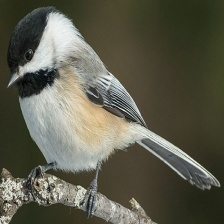

In [7]:
from PIL import Image

# 1. Get the image paths (* is a wildcard)
image_path_list = list(image_path.glob('*/*/*.jpg'))

# 2. Get a random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name.
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

The same can be done with [`matplotlib.pyplot.imshow()`](https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.imshow.html), except we have to convert the image to a NumPy array first.

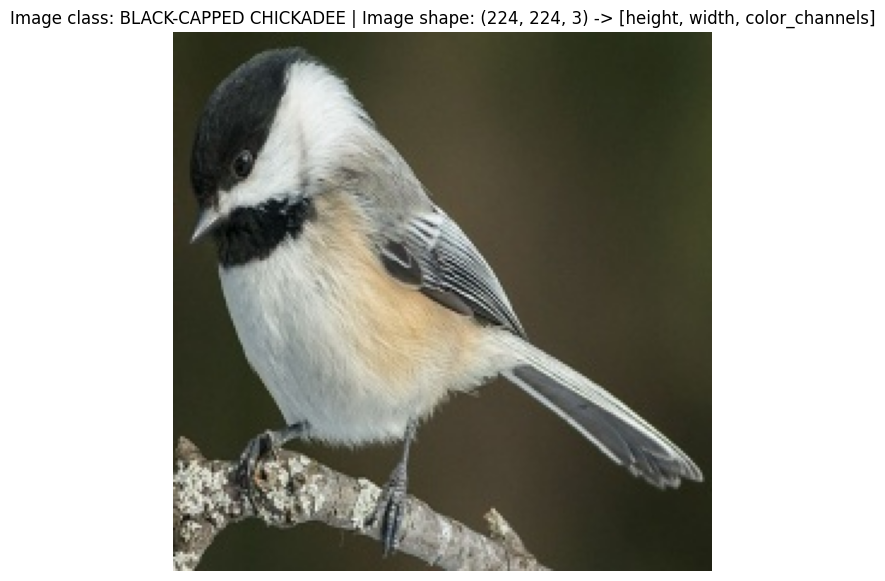

In [8]:
# Turn the image into a np.array
img_as_array = np.asarray(img)

#Plot with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

### More visualization

Let's see the distribution of the data using [`pandas`](https://pandas.pydata.org/).

We can use the `bird.csv` file which contains tabular information of the dataset into a [`pandas.DataFrame`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html).



In [9]:
labels_csv = pd.read_csv("./birds.csv") #Entire train, valid, and test set
print(labels_csv.describe())
print(labels_csv.head())
print("Unique breeds:", len(labels_csv['class id'].unique()))

           class id
count  75126.000000
mean     225.080172
std      130.126655
min        0.000000
25%      112.000000
50%      226.000000
75%      337.000000
max      449.000000
   class id                      filepaths           labels  \
0         0  train/ABBOTTS BABBLER/001.jpg  ABBOTTS BABBLER   
1         0  train/ABBOTTS BABBLER/002.jpg  ABBOTTS BABBLER   
2         0  train/ABBOTTS BABBLER/003.jpg  ABBOTTS BABBLER   
3         0  train/ABBOTTS BABBLER/004.jpg  ABBOTTS BABBLER   
4         0  train/ABBOTTS BABBLER/005.jpg  ABBOTTS BABBLER   

       scientific label data set  
0  Malacocincla abbotti    train  
1  Malacocincla abbotti    train  
2  Malacocincla abbotti    train  
3  Malacocincla abbotti    train  
4  Malacocincla abbotti    train  
Unique breeds: 450


Looking at this, we can see there are 70626 different images and 450 different breeds.

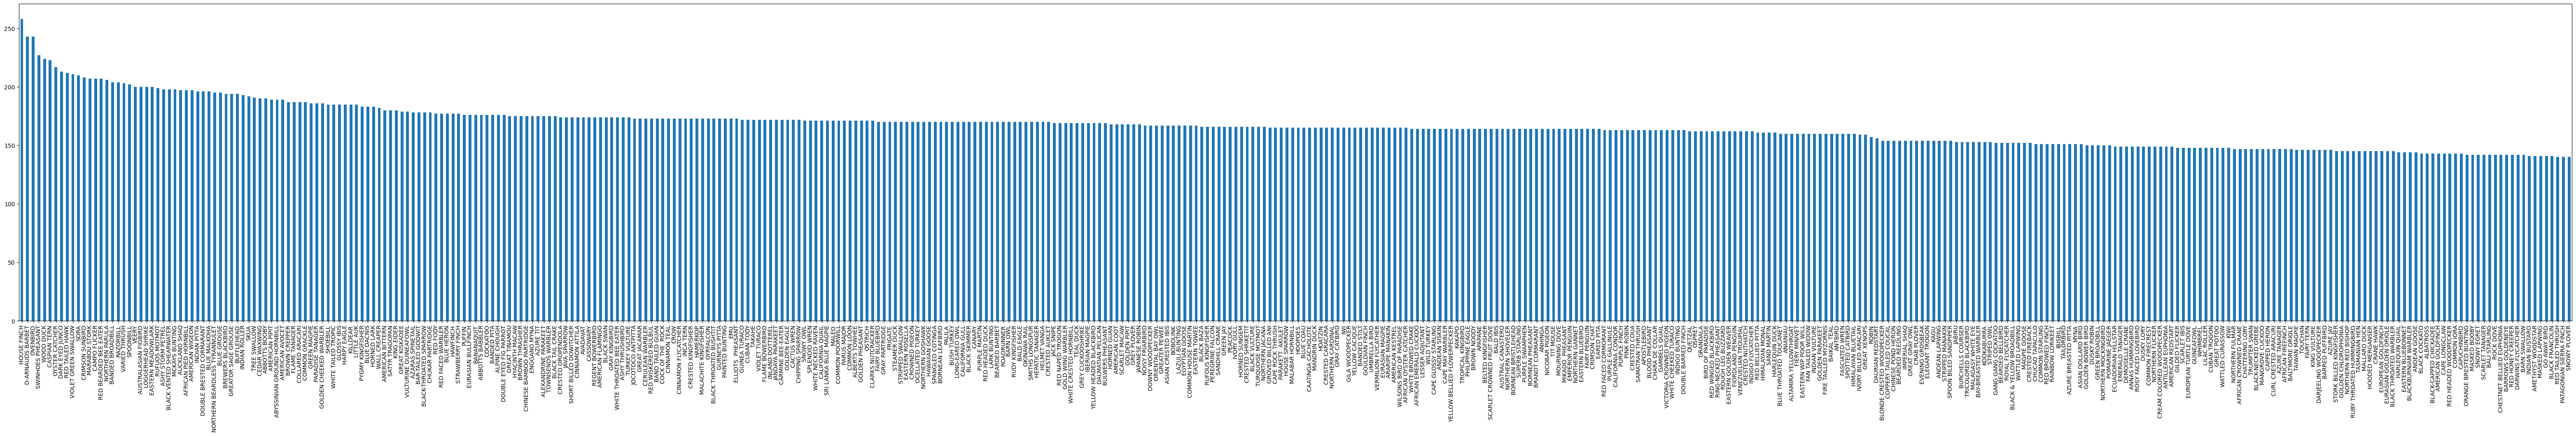

In [10]:
labels_csv['labels'].value_counts().plot.bar(figsize=(80, 10));

If we roughly draw a line across the middle of the graph, we'd see there's about 150+ images for each bird breed

This is a good amount as for some of their vision products [Google recommends a minimum of 10 images per class to get started](https://cloud.google.com/vision/automl/object-detection/docs/prepare). And as you might imagine, the more images per class available, the more chance a model has to figure out patterns between them.


### Transforming data with `torchvision.transform`

We've got folders of images, but before we can use them with PyTorch, we need to convert them into tensors.

One of the ways we can do this is by using the `torchvision.transforms` module.

`torchvision.transforms` contains many pre-built methods for formatting images, turing them into tensors and even manipulating them for **data augmentation** (the practice of altering data to make it harder for a model to learn) purposes.

To get experience with `torchvision.transform`, let's write a series of transforms that:
1. Resize the images using transform.Resize() (from 224x224 to 150x150)
2. Flip our images on the horizontal using transforms.RandomHorizontalFlip() (
3. Turn our images from a PIL image to a PyTorch tensor using transforms.ToTensor()

We can compile all of these steps using `torchvision.transforms.Compose()`.

**Note**: If you are running this **locally**, follow these [instructions](https://pytorch.org/get-started/locally/) to set up PyTorch and also make sure you have [CUDA Toolkit 12.0](https://developer.nvidia.com/cuda-downloads?target_os=Windows&target_arch=x86_64&target_version=10&target_type=exe_network) - more info at [CUDA NVIDIA (for windows)](https://docs.nvidia.com/cuda/cuda-installation-guide-microsoft-windows/index.html)

In [11]:
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
data_transforms = {
    'train': transforms.Compose([
        # Resize the images to 150x150
        transforms.Resize(size=(150,150)),
        # Flip the images randomly on the horizontal
        transforms.RandomHorizontalFlip(p=0.5),
        # Turn the image into a torch.Tensor
        transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=(150,150)),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=(150,150)),
        transforms.ToTensor(),
    ])
}

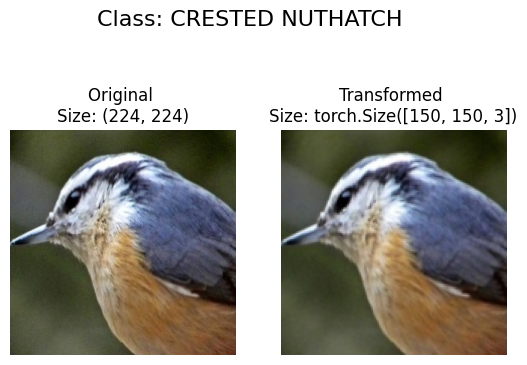

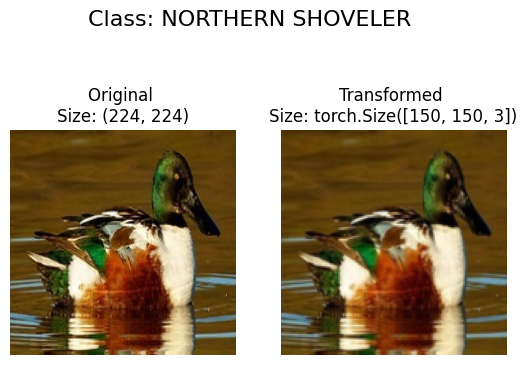

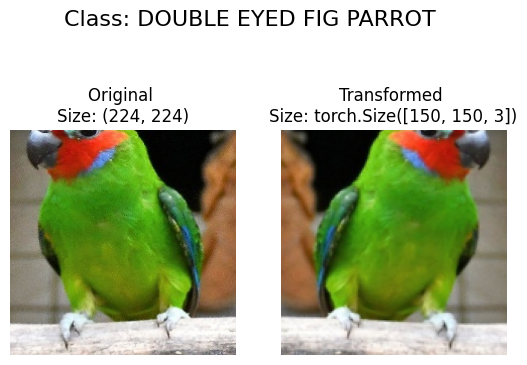

In [12]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """ Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transforms
    them with torchvision.transforms and plot them side by side.

    :param image_paths: List of target image paths
    :param transform: PyTorch Transforms (https://pytorch.org/vision/stable/transforms.html) to apply to the images.
    :param n: Numer of images to plot. Default set to 3.
    :param seed: Random seed for the random generator. Default set to 42.
    :return: void
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f'Original \nSize: {f.size}')
            ax[0].axis('off')

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C]
            transformed_image = transform(f).permute(1,2,0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f'Transformed \nSize: {transformed_image.shape}')
            ax[1].axis('off')

            fig.suptitle(f'Class: {Path(image_path).parent.stem}', fontsize=16)

plot_transformed_images(
    image_paths=image_path_list,
    transform=data_transforms['train'],
    n=3,
    seed=None
)

Now we've got a composition of transforms, let's write a function to try them out on various images

## Loading Image Data Using `ImageFolder`
Alright, time to turn our image data into a `Dataset` capable of being used with PyTorch.

Since our data is in standard image classification format, we can use the class `torchvision.datasets.ImageFolder`.

Where we can pass it the file path of a target image directory as well as a series of transforms we'd like to perform on our images.

Let's test it out on our data folders `train_dir` and `test_dir` passing `transform=data_transform` to turn our images into tensors.

In [13]:
data_dir = 'data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid','test']}
print(f"Train data:\n{image_datasets['train']}\nValidation data: {image_datasets['valid']}\nTest data:\n{image_datasets['test']}")

Train data:
Dataset ImageFolder
    Number of datapoints: 70626
    Root location: data\train
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Validation data: Dataset ImageFolder
    Number of datapoints: 2250
    Root location: data\valid
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 2250
    Root location: data\test
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )


Perfect!

It looks like PyTorch has registered our `Dataset`'s.

Let's inspect them by checking out the `classes` and `class_to_idx` attributes as well as the lengths of our training and test sets.

In [14]:
# Get class names as a list
class_names = image_datasets['train'].classes
class_names

['ABBOTTS BABBLER',
 'ABBOTTS BOOBY',
 'ABYSSINIAN GROUND HORNBILL',
 'AFRICAN CROWNED CRANE',
 'AFRICAN EMERALD CUCKOO',
 'AFRICAN FIREFINCH',
 'AFRICAN OYSTER CATCHER',
 'AFRICAN PIED HORNBILL',
 'ALBATROSS',
 'ALBERTS TOWHEE',
 'ALEXANDRINE PARAKEET',
 'ALPINE CHOUGH',
 'ALTAMIRA YELLOWTHROAT',
 'AMERICAN AVOCET',
 'AMERICAN BITTERN',
 'AMERICAN COOT',
 'AMERICAN FLAMINGO',
 'AMERICAN GOLDFINCH',
 'AMERICAN KESTREL',
 'AMERICAN PIPIT',
 'AMERICAN REDSTART',
 'AMERICAN WIGEON',
 'AMETHYST WOODSTAR',
 'ANDEAN GOOSE',
 'ANDEAN LAPWING',
 'ANDEAN SISKIN',
 'ANHINGA',
 'ANIANIAU',
 'ANNAS HUMMINGBIRD',
 'ANTBIRD',
 'ANTILLEAN EUPHONIA',
 'APAPANE',
 'APOSTLEBIRD',
 'ARARIPE MANAKIN',
 'ASHY STORM PETREL',
 'ASHY THRUSHBIRD',
 'ASIAN CRESTED IBIS',
 'ASIAN DOLLARD BIRD',
 'AUCKLAND SHAQ',
 'AUSTRAL CANASTERO',
 'AUSTRALASIAN FIGBIRD',
 'AVADAVAT',
 'AZARAS SPINETAIL',
 'AZURE BREASTED PITTA',
 'AZURE JAY',
 'AZURE TANAGER',
 'AZURE TIT',
 'BAIKAL TEAL',
 'BALD EAGLE',
 'BALD IBIS',
 'BALI

In [15]:
class_dict = image_datasets['train'].class_to_idx
class_dict

{'ABBOTTS BABBLER': 0,
 'ABBOTTS BOOBY': 1,
 'ABYSSINIAN GROUND HORNBILL': 2,
 'AFRICAN CROWNED CRANE': 3,
 'AFRICAN EMERALD CUCKOO': 4,
 'AFRICAN FIREFINCH': 5,
 'AFRICAN OYSTER CATCHER': 6,
 'AFRICAN PIED HORNBILL': 7,
 'ALBATROSS': 8,
 'ALBERTS TOWHEE': 9,
 'ALEXANDRINE PARAKEET': 10,
 'ALPINE CHOUGH': 11,
 'ALTAMIRA YELLOWTHROAT': 12,
 'AMERICAN AVOCET': 13,
 'AMERICAN BITTERN': 14,
 'AMERICAN COOT': 15,
 'AMERICAN FLAMINGO': 16,
 'AMERICAN GOLDFINCH': 17,
 'AMERICAN KESTREL': 18,
 'AMERICAN PIPIT': 19,
 'AMERICAN REDSTART': 20,
 'AMERICAN WIGEON': 21,
 'AMETHYST WOODSTAR': 22,
 'ANDEAN GOOSE': 23,
 'ANDEAN LAPWING': 24,
 'ANDEAN SISKIN': 25,
 'ANHINGA': 26,
 'ANIANIAU': 27,
 'ANNAS HUMMINGBIRD': 28,
 'ANTBIRD': 29,
 'ANTILLEAN EUPHONIA': 30,
 'APAPANE': 31,
 'APOSTLEBIRD': 32,
 'ARARIPE MANAKIN': 33,
 'ASHY STORM PETREL': 34,
 'ASHY THRUSHBIRD': 35,
 'ASIAN CRESTED IBIS': 36,
 'ASIAN DOLLARD BIRD': 37,
 'AUCKLAND SHAQ': 38,
 'AUSTRAL CANASTERO': 39,
 'AUSTRALASIAN FIGBIRD': 40,
 '

In [16]:
len(image_datasets['train']), len(image_datasets['valid']), len(image_datasets['test'])

(70626, 2250, 2250)

Great! Looks like we'll be able to use these to reference for later.

How about our images and labels?

How do they look?

We can index on our `train_data` and `test_data` `Dataset`'s to find samples and their target labels.

In [17]:
img, label = image_datasets['train'][0][0], image_datasets['train'][0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.7176, 0.7373, 0.7608,  ..., 0.7333, 0.7098, 0.6980],
         [0.7373, 0.7608, 0.7765,  ..., 0.7294, 0.7137, 0.7059],
         [0.7529, 0.7804, 0.7922,  ..., 0.7294, 0.7137, 0.7137],
         ...,
         [0.7255, 0.7569, 0.8000,  ..., 0.7176, 0.7098, 0.6745],
         [0.6275, 0.6745, 0.6941,  ..., 0.6235, 0.7176, 0.6863],
         [0.6157, 0.6353, 0.6824,  ..., 0.6392, 0.6902, 0.6471]],

        [[0.6863, 0.7098, 0.7373,  ..., 0.7294, 0.7098, 0.7020],
         [0.7059, 0.7373, 0.7490,  ..., 0.7255, 0.7098, 0.7059],
         [0.7216, 0.7529, 0.7647,  ..., 0.7255, 0.7098, 0.7098],
         ...,
         [0.6745, 0.7098, 0.7569,  ..., 0.7216, 0.7020, 0.6627],
         [0.5725, 0.6235, 0.6471,  ..., 0.6353, 0.7216, 0.6863],
         [0.5529, 0.5843, 0.6353,  ..., 0.6549, 0.7020, 0.6627]],

        [[0.6000, 0.6235, 0.6510,  ..., 0.7961, 0.7804, 0.7804],
         [0.6275, 0.6588, 0.6706,  ..., 0.7882, 0.7765, 0.7804],
         [0.6549, 0.6824, 0.6980,  ..., 0.78

Our images are now in the form of a tensor (with shape [3, 150, 150]) and the labels are in the form of an integer relating to a specific class (as referenced by the `class_to_idx` attribute).

How about we plot a single image tensor using `matplotlob`?

We'll first have to permute (rearrange the order of its dimensions) so it's compatible.

Right now our image dimensions are in the format `CHW` (color channels, height, width) but `matplotlib` prefers `HWC` (height, width, color channels).

Original shape: torch.Size([3, 150, 150]) -> [color_channels, height, width]
Image permute shape: torch.Size([150, 150, 3]) -> [height, width, color_channel]


Text(0.5, 1.0, 'ABBOTTS BABBLER')

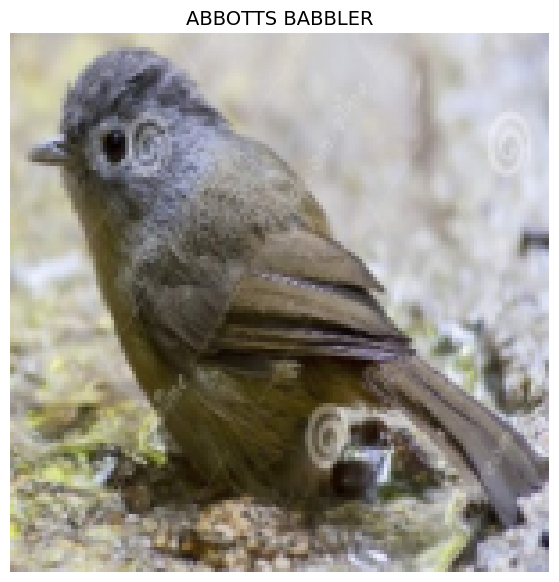

In [18]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Prints out different shapes (before and after permute)
print(f'Original shape: {img.shape} -> [color_channels, height, width]')
print(f'Image permute shape: {img_permute.shape} -> [height, width, color_channel]')

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis('off')
plt.title(class_names[label], fontsize=14)

Notice the image is now more pixelated (less quality)

This is due to it being resized from `224x224` to `150x150` pixels.

The intuition here is that if you think the image is harder to recognize what's going on, chances are a model will find it harder to understand too.

## Turn loaded images into `DataLoader`'s

We've got our images as PyTorch `Dataset`'s but now let's turn them into `DataLoader`'s.

We'll do so using `torch.utils.data.DataLoader`.

Turing our `Dataset`'s into `DataLoader`'s makes them iterable so a model can go through learn the relationships between samples and targets (features and labels).

To keep things simple, we'll use a `batch_size=1` and `num_workers=1`.

What's `num_workers`?

Good question.

It defines how many subprocesses will be created to load your data.

Think of it like this, the higher value `num_workers` is set to, the more compute power PyTorch will use to load your data.

Personally, I usually set it to the total number of CPUs on my machine via Python's `os.cpu_count()`.

This ensures the `DataLoader` recruits as many cores as possible to load data.

**Note:** There are more parameters you can get familiar with using `torch.utils.data.DataLoader` in the PyTorch [documentation](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)


In [19]:
os.cpu_count()

8

In [20]:
# Turn train and test Datasets into DataLoader
train_dataloader = DataLoader(dataset=image_datasets['train'],
                              batch_size=16,    # how many samples per batch?
                              num_workers=8,    # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True)     # shuffle the data?

valid_dataloader = DataLoader(dataset=image_datasets['valid'],
                             batch_size=16,
                             num_workers=8,
                             shuffle=False) # don't usually need to shuffle validation data

test_dataloader = DataLoader(dataset=image_datasets['valid'],
                             batch_size=16,
                             num_workers=8,
                             shuffle=False) # don't usually need to shuffle testing data


train_dataloader, valid_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1f22b67ae20>,
 <torch.utils.data.dataloader.DataLoader at 0x1f22b66cc40>)

Now our data is iterable.

Let's try it out and check the shapes.

In [21]:
img, label = next(iter(train_dataloader))

# Batch size will now be 32, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([16, 3, 150, 150]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([16])


We could now use these `DataLoader`'s with a training and testing loop to train a model.

But before we do, let's look at another option to load images (or almost any other kind of data).

## Other forms of transforms (data augmentation)

**Data augmentation** is the process of artificially adding diversity to your training data.

In the case of image data, this may mean applying various image transformation to the training images.

This practice hopefully results in a model that's more generalizable to unseen data.

Here is an example of **RandAugment** from PyTorch's documentation on [data augmentation](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py):

![RandAugment](https://pytorch.org/vision/stable/_images/sphx_glr_plot_transforms_021.png)

### Let's take a look at one particular type of [data augmentation](https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/) used to train PyTorch vision models to state-of-the-art levels

[Blog post](https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/)

In [22]:
# Paper on trivial augment - https://arxiv.org/abs/2103.10158
data_transforms['train'] = transforms.Compose([
    transforms.Resize(size=(150,150)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

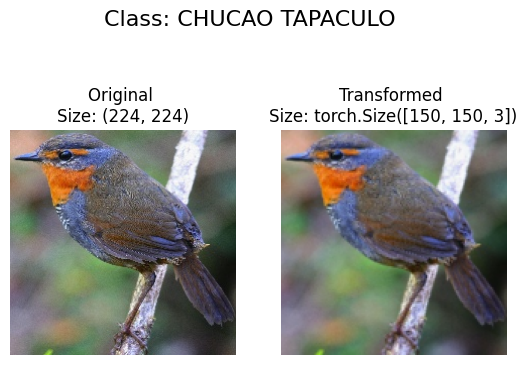

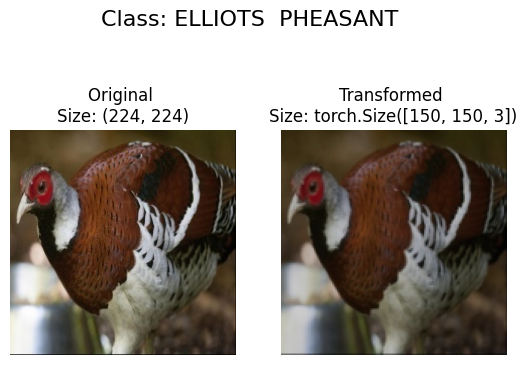

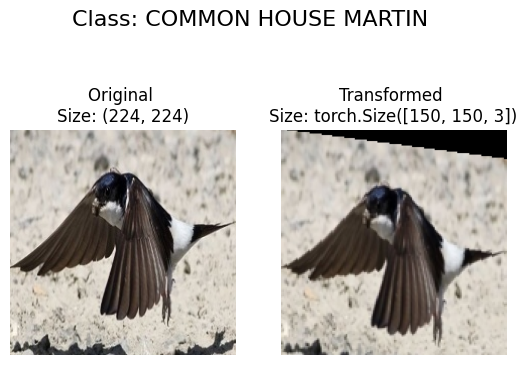

In [23]:
# Plot random transformed images
plot_transformed_images(
    image_paths=image_path_list,
    transform=data_transforms['train'],
    n=3,
    seed=None
)

# Model 0: [TinyVGG](https://poloclub.github.io/cnn-explainer/) without data augmentation
## Creating transforms and loading data for Model 0

In [24]:
# Create simple transform
data_transforms.update({'simple_transform': transforms.Compose([
    transforms.Resize(size=(150, 150)),
    transforms.ToTensor()
])})
print(data_transforms)

{'train': Compose(
    Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=None)
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ToTensor()
), 'valid': Compose(
    Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
), 'test': Compose(
    Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
), 'simple_transform': Compose(
    Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)}


In [25]:
# 1. Load and transform data
image_datasets.update({'train_simple':datasets.ImageFolder(os.path.join(data_dir, 'train'),
                                          transform=data_transforms['simple_transform'])})

# 2. Turn the datasets into DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create DataLoaders
train_dataloader_simple = DataLoader(dataset=image_datasets['train_simple'],
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=True)

In [26]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from CNN Explainer: https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int,
                 hidden_units: int,
                 output_shape: int) -> None:
        super(TinyVGG, self).__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)  #default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)  #default stride value is same as kernel_size
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*34*34,
                      out_features=output_shape)
        )

    def forward(self, x):
        # x = self.conv_block_1(x)
        # # print(x.shape)
        # x = self.conv_block_2(x)
        # # print(x.shape)
        # x = self.classifier(x)
        # # print(x.shape)
        # return x
        return self.classifier(self.conv_block_2(self.conv_block_1(x))) # benefits from operator fusion

In [27]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3,    # number of color channels in our image data
                  hidden_units=20,
                  output_shape=len(class_names)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=23120, out_features=450, bias=True)
  )
)

### Try a forward pass on a single image to test if the forward pass works

In [28]:
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 150, 150]), torch.Size([32]))

In [29]:
# Try a forward pass
model_0(image_batch.to(device))

tensor([[-0.0051, -0.0007,  0.0071,  ...,  0.0025,  0.0095, -0.0104],
        [-0.0022,  0.0011,  0.0076,  ...,  0.0033,  0.0071, -0.0107],
        [-0.0049, -0.0017,  0.0062,  ...,  0.0038,  0.0104, -0.0127],
        ...,
        [-0.0078,  0.0025,  0.0078,  ...,  0.0064,  0.0091, -0.0109],
        [-0.0042, -0.0007,  0.0076,  ...,  0.0040,  0.0102, -0.0104],
        [-0.0053, -0.0016,  0.0069,  ...,  0.0051,  0.0096, -0.0117]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

### Use `torchinfo` to get an idea of the shapes going through the model

In [30]:
from torchinfo import summary
summary(model_0, input_size=[1,3,150,150])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 450]                  --
├─Sequential: 1-1                        [1, 20, 73, 73]           --
│    └─Conv2d: 2-1                       [1, 20, 148, 148]         560
│    └─ReLU: 2-2                         [1, 20, 148, 148]         --
│    └─Conv2d: 2-3                       [1, 20, 146, 146]         3,620
│    └─ReLU: 2-4                         [1, 20, 146, 146]         --
│    └─MaxPool2d: 2-5                    [1, 20, 73, 73]           --
├─Sequential: 1-2                        [1, 20, 34, 34]           --
│    └─Conv2d: 2-6                       [1, 20, 71, 71]           3,620
│    └─ReLU: 2-7                         [1, 20, 71, 71]           --
│    └─Conv2d: 2-8                       [1, 20, 69, 69]           3,620
│    └─ReLU: 2-9                         [1, 20, 69, 69]           --
│    └─MaxPool2d: 2-10                   [1, 20, 34, 34]           --
├─Seq

### Create train and test loops functions

* `train_step()` - takes in a model and data loader and trains the model on the dataloader.
* `test_step()` - takes in a model and dataloader and evaluates the model on the dataloader.

In [31]:
# Create train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put the model in train mode
    model.train()
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        # Send data to the target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate the loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate accuracy metric
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class==y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [32]:
# Create test_step()
def test_step(model:torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference mode
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to the target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate the loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate the accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item() / len(test_pred_labels))

        # Adjust metrics to get average loss and accuracy per batch
        test_loss = test_loss / len(dataloader)
        test_acc = test_acc / len(dataloader)
        return test_loss, test_acc

### Creating a `train()` function to combine `train_step()` and `test_step()`

In [33]:
from tqdm.auto import tqdm

# 1. Create a train function that takes in various model parameters + optimizer +
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    # 2. Create empty results dictionary
    results = {'train_loss': [],
               'train_acc': [],
               'test_loss': [],
               'test_acc': []}

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):

        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn)
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )
        # 5. Update results dictionary
        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

### Train and evaluate Model 0

In [34]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 10

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3,
                  hidden_units=30,
                  output_shape=len(class_names)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f'Total training time: {end_time-start_time:.3f} seconds')


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 6.1094 | train_acc: 0.0030 | test_loss: 6.1105 | test_acc: 0.0022
Epoch: 2 | train_loss: 6.1061 | train_acc: 0.0034 | test_loss: 6.1121 | test_acc: 0.0022
Epoch: 3 | train_loss: 6.1054 | train_acc: 0.0035 | test_loss: 6.1133 | test_acc: 0.0022
Epoch: 4 | train_loss: 6.1051 | train_acc: 0.0035 | test_loss: 6.1140 | test_acc: 0.0022
Epoch: 5 | train_loss: 6.1051 | train_acc: 0.0035 | test_loss: 6.1145 | test_acc: 0.0022
Epoch: 6 | train_loss: 6.1050 | train_acc: 0.0035 | test_loss: 6.1147 | test_acc: 0.0022
Epoch: 7 | train_loss: 6.1051 | train_acc: 0.0035 | test_loss: 6.1148 | test_acc: 0.0022
Epoch: 8 | train_loss: 6.1050 | train_acc: 0.0035 | test_loss: 6.1149 | test_acc: 0.0022
Epoch: 9 | train_loss: 6.1051 | train_acc: 0.0035 | test_loss: 6.1150 | test_acc: 0.0022
Epoch: 10 | train_loss: 6.1050 | train_acc: 0.0035 | test_loss: 6.1150 | test_acc: 0.0022
Total training time: 2863.334 seconds


## Plot the loss curves for Model 0

From the print out of our `Model 0`, it didn't look like it did too well.

But we can further evaluate it byu plotting the model's **loss curves**.

**Loss curves** show the model's results over time.

And they're a great way to see how your model performs on different datasets (e.g. training and test).

Let's create a function to plot the values in our `model_0_results` dictionary.

[Interpreting loss curves](https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic)

In [35]:
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

We'll extract each of these keys and turn them into a plot.

In [36]:
from typing import Dict, List
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Figure out how accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

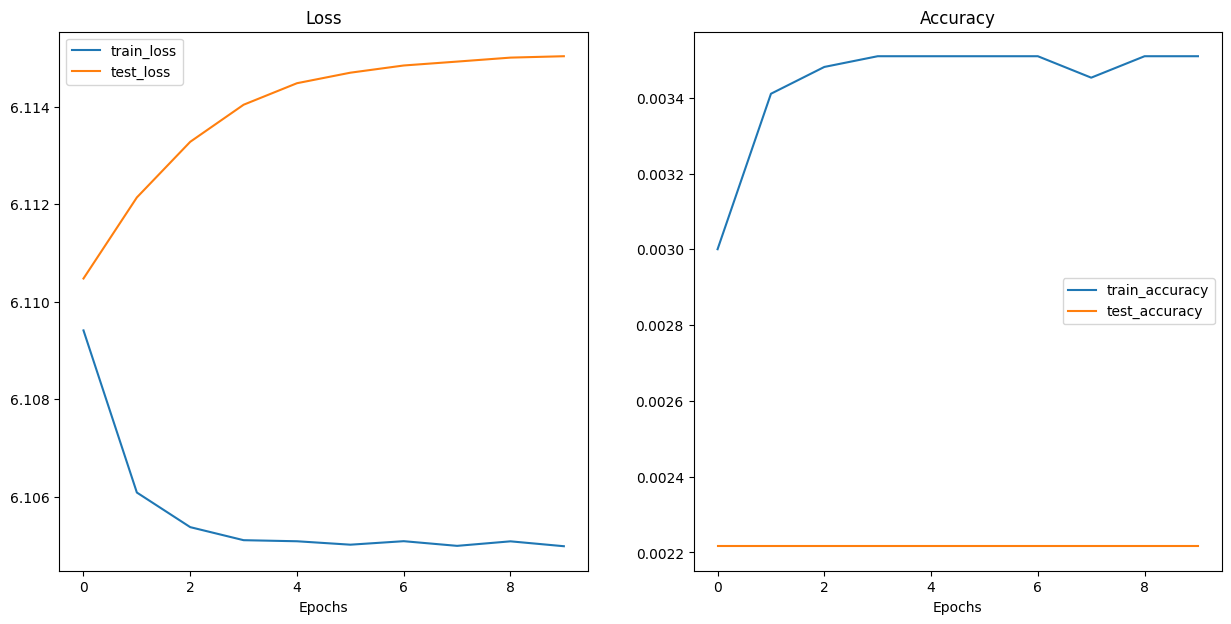

In [37]:
plot_loss_curves(model_0_results)

# Create train `Dataset`'s and `DataLoader`'s with data augmentation

In [38]:
# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform=data_transforms['train'])

In [39]:
# Turn our Datasets into DataLoaders
train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

### Construct and train model 1

This time we'll be using the same model architecture except this time we've augmented the training data.

In [40]:
# Create model_1 and send to target device
model_1 = TinyVGG(input_shape=3,
                  hidden_units=20,
                  output_shape=len(train_data_augmented)).to(device)

model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=23120, out_features=70626, bias=True)
  )
)

In [41]:
# Start the timer
start_time = timer()

# Train model_1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f'Total training time: {end_time-start_time:.3f} seconds')

  0%|          | 0/10 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 6.08 GiB (GPU 0; 8.00 GiB total capacity; 6.74 GiB already allocated; 0 bytes free; 6.92 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

### Plot the loss curves for model_1

In [ ]:
plot_loss_curves(model_1_results)

In [49]:
import gc
def report_gpu():
    print(torch.cuda.list_gpu_processes())
    gc.collect()
    torch.cuda.empty_cache()

report_gpu()

TypeError: unsupported operand type(s) for /: 'NoneType' and 'int'

In [50]:
!nvidia-smi

Sat Jan 21 22:26:18 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 527.56       Driver Version: 527.56       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 23%   53C    P0    43W / 198W |   7897MiB /  8192MiB |      6%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------